In [1]:
!wget https://sansi-apk-manager.s3.cn-north-1.amazonaws.com.cn/tools/captcha_datasets.tar.gz
!tar -xzf captcha_datasets.tar.gz

--2021-03-12 13:25:42--  https://sansi-apk-manager.s3.cn-north-1.amazonaws.com.cn/tools/captcha_datasets.tar.gz
Resolving sansi-apk-manager.s3.cn-north-1.amazonaws.com.cn (sansi-apk-manager.s3.cn-north-1.amazonaws.com.cn)... 54.222.50.126
Connecting to sansi-apk-manager.s3.cn-north-1.amazonaws.com.cn (sansi-apk-manager.s3.cn-north-1.amazonaws.com.cn)|54.222.50.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 359955897 (343M) [binary/octet-stream]
Saving to: ‘captcha_datasets.tar.gz’

captcha_datasets.ta 100%[===================>] 343.28M  20.6MB/s    in 29s     

2021-03-12 13:26:13 (11.7 MB/s) - ‘captcha_datasets.tar.gz’ saved [359955897/359955897]



In [2]:
!pip install matplotlib

     |████████████████████████████████| 11.5 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 28.1 MB/s eta 0:00:01    |▉                               | 30 kB 23.5 MB/s eta 0:00:01


In [1]:
import torch.utils.data.dataloader as dataloader
import torch.utils.data.dataset as dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch
import glob
import PIL.Image as Image
import os
import numpy as np
import math
import torch.nn as nn
import time
import matplotlib.pyplot as plt

In [2]:

class CodeDataset(dataset.Dataset):
    def __init__(self, basedir):
        self.files = glob.glob(basedir + "*.png")
        self.pre_process =transforms.Compose(
            [transforms.ToTensor()
             ,transforms.Normalize(mean=[0.5], std=[0.5])
            ])

    def __getitem__(self, index):
        file = self.files[index]
        name = os.path.basename(file).rstrip(".png")
        label = name[(name.index('_') + 1):]
        image = Image.open(file)
        numbs = [ord(x) - ord('0') for x in label]
        assert len(numbs) >= 2
        #         one_hots = np.zeros((len(numbs), 10))
        #         one_hots[np.arange(0, len(label)), numbs] = 1
        #         return self.pre_process(image), one_hots.reshape(40)
        return self.pre_process(image), torch.LongTensor(numbs)

    def __len__(self):
        return len(self.files)


In [3]:
def collate_fn(batch):
    sequence_lengths = []
    max_width, max_height = 0, 0
    for image, label in batch:
        if image.size(1) > max_height:
            max_height = image.size(1)
        if image.size(2) > max_width:
            max_width = image.size(2)
        sequence_lengths.append(label.size(0))
    seq_lengths = torch.LongTensor(sequence_lengths)
    seq_tensor = torch.zeros(seq_lengths.size(0), seq_lengths.max()).long()
    img_tensor = torch.zeros(seq_lengths.size(0), 3, max_height, max_width)
    for idx, (image, label) in enumerate(batch):
        seq_tensor[idx, :label.size(0)] = label
        img_tensor[idx, :, :image.size(1), :image.size(2)] = image

    return img_tensor, seq_tensor, seq_lengths

In [4]:
USE_GPU =torch.cuda.is_available()
print("USE GPU:",USE_GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 100

trainset = CodeDataset('captcha_datasets_var/train-data/')

# 防止最后一个batch_size=1，如果最后一个batch_size=1就舍去
drop_last = True if len(trainset) % BATCH_SIZE == 1 else False
nw = min([os.cpu_count(), BATCH_SIZE if BATCH_SIZE > 1 else 0, 8])  # number of workers
print('Using %g dataloader workers' % nw)

trainloader = dataloader.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,num_workers=nw,
                                    drop_last=drop_last, collate_fn=collate_fn)

validset = CodeDataset('captcha_datasets_var/valid-data/')
validloader = dataloader.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False,num_workers=nw, collate_fn=collate_fn)

testset = CodeDataset('captcha_datasets_var/test-data/')
testloader = dataloader.DataLoader(testset, batch_size=81,shuffle=True, collate_fn=collate_fn)

USE GPU: True
Using 8 dataloader workers


In [5]:


def _make_convolutional(in_channels,
                        out_channels,
                        kernel_size,
                        stride=1,
                        padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size,
                  stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, 1,1,0,bias=False)
        self.bn1=nn.BatchNorm2d(in_channels//2)
        self.conv2 = nn.Conv2d(in_channels // 2, in_channels, 3, 1, 1,bias=False)
        self.bn2=nn.BatchNorm2d(in_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += input
        x = self.relu(x)
        return x


class QLNet(nn.Module):
    def __init__(self):
        super(QLNet, self).__init__()
        self.conv1 = _make_convolutional(3, 32, 3, 1, 1)
        self.conv2 = _make_convolutional(32, 64, 3, 2, 1)
        self.layer1 = self._make_layer(64, 1)
        self.conv3 = _make_convolutional(64, 128, 3, 2, 1)
        self.layer2 = self._make_layer(128, 2)
#         self.conv4 = _make_convolutional(128, 256, 3,2, 1)
#         self.layer3 = self._make_layer(256, 1)
#         self.conv5 = _make_convolutional(256, 512, 3, 2, 1)
#         self.layer4 = self._make_layer(512, 1)
#         self.conv6 = _make_convolutional(512, 1024, 3, (2,1), 1)
#         self.layer5 = self._make_layer(1024, 1)
        self.adapt_max_pool2d = nn.AdaptiveMaxPool2d((1, 40))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')

    def _make_layer(self, in_channels, repeat_count):
        layers = []
        for _ in range(repeat_count):
            layers.append(ResidualBlock(in_channels))
        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.layer1(x)
        x = self.conv3(x)
        x = self.layer2(x)
#         x = self.conv4(x)
#         x = self.layer3(x)
#         x = self.conv5(x)
#         x = self.layer4(x)
#         x = self.conv6(x)
#         x = self.layer5(x)
        x=self.adapt_max_pool2d(x)
        return x


In [6]:
qlnet=QLNet()
for images,labels,_ in trainloader:
    print('labels.size:',labels.size())
    print(images.size())
    output=qlnet(images)
    print(output.shape)
    break

labels.size: torch.Size([100, 10])
torch.Size([100, 3, 60, 400])
torch.Size([100, 128, 1, 40])


In [7]:
class Model(nn.Module):
    def __init__(self, output_size):
        super(Model,self).__init__()
        self.feature_extractor = QLNet()
        self.num_layers = 2
        self.n_directions = 2
        self.hidden_size = 80
        self.gru = nn.GRU(input_size=128, hidden_size=self.hidden_size,
                          num_layers=self.num_layers,
                          bidirectional=True, batch_first=True)
        self.fc = nn.Linear(self.hidden_size * self.n_directions, output_size)
        self.log_softmax = nn.LogSoftmax(2)
    def forward(self,input):
        x = self.feature_extractor(input)
        x = x.squeeze(2)
        x = x.permute(0, 2, 1)
        hidden = torch.zeros((self.num_layers * self.n_directions,
                             x.size(0), self.hidden_size),device=device)
        
        output, hidden = self.gru(x, hidden)
        x = self.fc(output)
        x = x.permute(1, 0, 2)
        output = self.log_softmax(x)
        output_lengths = torch.full(size=(x.size(1),), fill_value=x.size(0), dtype=torch.long,device=device)
        return output, output_lengths

In [17]:
!pip install torchsummary

In [9]:
from torchsummary import summary
class_num = 11
net = Model(class_num)
net=net.to(device)
summary(net, (3, 60, 160))

def create_tensor(tensor):
    tensor = tensor.to(device)
    return tensor

criterion = torch.nn.CTCLoss(blank=class_num - 1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def calculat_acc(output, target, target_lengths):
    output = torch.argmax(output, dim=-1)
    output = output.permute(1, 0)

    correct_num = 0
    for predict, label, label_length in zip(output, target, target_lengths):
        predict = torch.unique_consecutive(predict)
        predict = predict[predict != (class_num - 1)]
        if (predict.size()[0] == label_length.item()
                and (predict == label[:label_length.item()]).all()):
            correct_num += 1

    return correct_num, target.size(0)

def train():
    total = 0
    correct = 0
    run_loss = []
    net.train()
    for i, (images, labels, label_lengths) in enumerate(trainloader, 0):
        images, labels, label_lengths = images.to(device), \
                                        labels.to(device), \
                                        label_lengths.to(device)
        optimizer.zero_grad()
        outputs, output_lengths = net(images)
#         label_lengths = torch.full(size=(labels.size(0),),
#                                    fill_value=labels.size(1), dtype=torch.long,device=device)
        loss = criterion(outputs, labels, output_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        c, t = calculat_acc(outputs.data, labels.data, label_lengths.data)
        correct += c
        total += t
        run_loss.append(loss.item())
    return 100 * correct / total,np.array(run_loss).mean()

def evaluate():
    total = 0
    correct = 0
    run_loss = []
    net.eval()
    with torch.no_grad():
        for data in validloader:
            images, labels, label_lengths = data
            images, labels, label_lengths = images.to(device), labels.to(device), \
                                            label_lengths.to(device)
            outputs, output_lengths = net(images)
#             label_lengths = torch.full(size=(labels.size(0),),
#                                        fill_value=labels.size(1), dtype=torch.long,device=device)
            loss = criterion(outputs, labels,output_lengths,label_lengths)
            run_loss.append(loss.item())
            c, t = calculat_acc(outputs, labels,label_lengths)
            correct += c
            total += t
    return 100 * correct / total,np.array(run_loss).mean()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 60, 160]             864
       BatchNorm2d-2          [-1, 32, 60, 160]              64
         LeakyReLU-3          [-1, 32, 60, 160]               0
            Conv2d-4           [-1, 64, 30, 80]          18,432
       BatchNorm2d-5           [-1, 64, 30, 80]             128
         LeakyReLU-6           [-1, 64, 30, 80]               0
            Conv2d-7           [-1, 32, 30, 80]           2,048
       BatchNorm2d-8           [-1, 32, 30, 80]              64
         LeakyReLU-9           [-1, 32, 30, 80]               0
           Conv2d-10           [-1, 64, 30, 80]          18,432
      BatchNorm2d-11           [-1, 64, 30, 80]             128
        LeakyReLU-12           [-1, 64, 30, 80]               0
    ResidualBlock-13           [-1, 64, 30, 80]               0
           Conv2d-14          [-1, 128,

In [10]:

accuracies = []
losses = []

TOTAL_EPOCH=30

for epoch in range(TOTAL_EPOCH):
    print("Epoch %d/%d"%(epoch,TOTAL_EPOCH))
    start=time.time()
    train_acc,train_loss=train()
    val_acc,val_loss = evaluate()
    if len(accuracies) == 0 or val_acc > max(accuracies):
        torch.save(net.state_dict(), 'vary_base_cov_mnist.pt')
    accuracies.append(val_acc)
    end=time.time()
    print("%ds loss: %.5f - accuracy: %.5f - val_loss: %.5f - val_accuracy: %.5f"%((end-start),train_loss,train_acc,val_loss,val_acc))

Epoch 0/30
41s loss: 2.74111 - accuracy: 0.00000 - val_loss: 2.56225 - val_accuracy: 0.00000
Epoch 1/30
42s loss: 1.45840 - accuracy: 26.52800 - val_loss: 0.12558 - val_accuracy: 88.26000
Epoch 2/30
42s loss: 0.05355 - accuracy: 94.46800 - val_loss: 0.03135 - val_accuracy: 96.22000
Epoch 3/30
42s loss: 0.02199 - accuracy: 97.18800 - val_loss: 0.03834 - val_accuracy: 94.82000
Epoch 4/30
42s loss: 0.01648 - accuracy: 97.75600 - val_loss: 0.01476 - val_accuracy: 97.98000
Epoch 5/30
42s loss: 0.01180 - accuracy: 98.32000 - val_loss: 0.01326 - val_accuracy: 98.06000
Epoch 6/30
42s loss: 0.00976 - accuracy: 98.45600 - val_loss: 0.01387 - val_accuracy: 97.70000
Epoch 7/30
43s loss: 0.00595 - accuracy: 99.04800 - val_loss: 0.00939 - val_accuracy: 98.45000
Epoch 8/30
43s loss: 0.00638 - accuracy: 99.02400 - val_loss: 0.00661 - val_accuracy: 98.97000
Epoch 9/30
42s loss: 0.00706 - accuracy: 98.91200 - val_loss: 0.00998 - val_accuracy: 98.19000
Epoch 10/30
42s loss: 0.00462 - accuracy: 99.14400 -

In [11]:
train_weights = "vary_base_cov_mnist.pt"
train_weights_dict = torch.load(train_weights)
model = Model(class_num)
model.load_state_dict(train_weights_dict, strict=True)
model.to(device)

Model(
  (feature_extractor): QLNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu)

Test Acc : 81/81


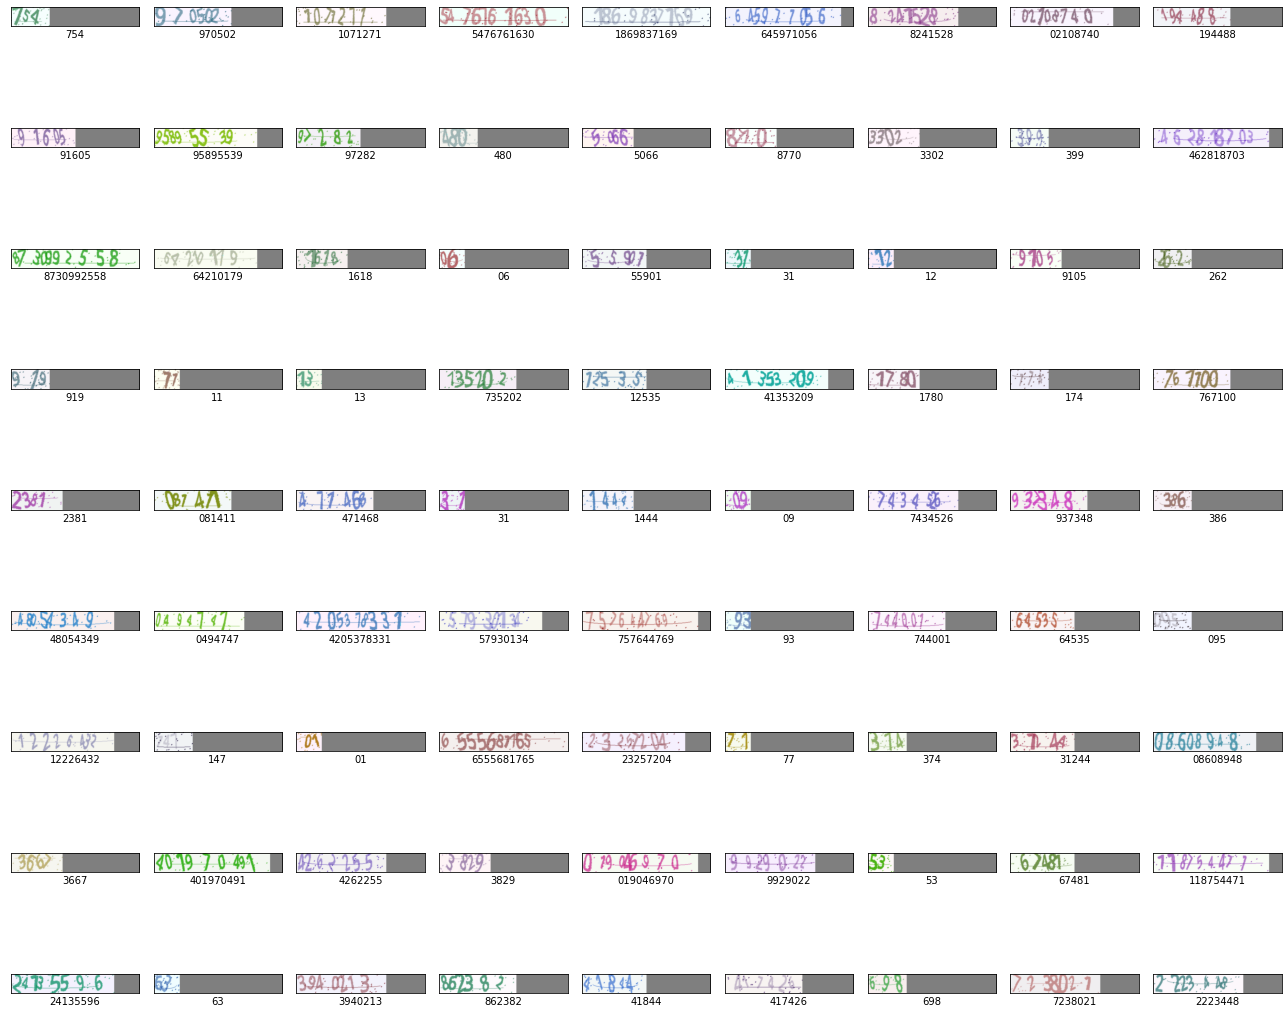

In [14]:
%matplotlib inline
dataiter=iter(testloader)
images,labels, label_lengths=dataiter.next()
model.eval()
results=[]
start=time.time()
with torch.no_grad():
    predicts = model(images.to(device))[0]
    predicts = predicts.cpu()
    output = torch.argmax(predicts, dim=-1)
    output = output.permute(1, 0)
    correct_num = 0
    for predict, label, label_length in zip(output, labels, label_lengths):
        predict = torch.unique_consecutive(predict)
        predict = predict[predict != (class_num - 1)]
        if (predict.size()[0] == label_length.item()
                and (predict == label[:label_length.item()]).all()):
            correct_num += 1
           
        results.append((predict.numpy(),label[:label_length.item()].numpy()))
test_dataX=images.to('cpu').numpy()
test_dataX=np.transpose(test_dataX,(0,2,3,1))
test_dataX=(test_dataX*0.5)+0.5
end=time.time()
print(f"Test Acc : {correct_num}/{len(results)}")
plt.figure(figsize=(18,16))
for i in range(len(test_dataX)):
    img=test_dataX[i]
    plt.subplot(9,9,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    label=''.join(map(str,results[i][0].tolist()))
    real_label=''.join(map(str,results[i][1].tolist()))
    if (results[i][0].shape==results[i][1].shape) and (results[i][0]==results[i][1]).all():
        color = 'blue'
        plt.xlabel(label)
    else:
        color = 'red'
        plt.xlabel('{}({})'.format(label,real_label), color=color)
  
    plt.imshow(img)
plt.tight_layout()
plt.show()

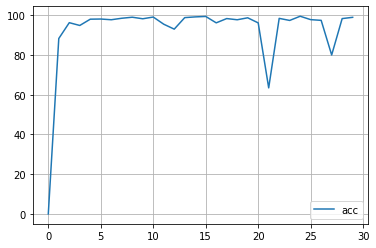

In [15]:
plt.plot(accuracies,label='acc')
plt.legend(loc='lower right')
plt.grid()
plt.show()